In [1]:
# kaggle speech emotion recognition Ex
# audio data preprocessing

import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Conv2D, LSTM, TimeDistributed, MaxPool1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
  warnings.simplefilter("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [2]:
Ravdess = "/content/drive/MyDrive/kaggle/archive/audio_speech_actors_01-24/"

In [3]:
dir_list = os.listdir(Ravdess)
dir_list.sort()

emotion = []
gender = []
path = []

for i in dir_list:
  fname = os.listdir(Ravdess + i)
  for f in fname:
    part = f.split('.')[0].split('-')
    emotion.append(int(part[2]))
    temp = int(part[6])
    if temp%2 == 0:
      temp = 'female'
    else:
      temp = 'male'
    gender.append(temp)
    path.append(Ravdess+i+'/'+f)

Rav_df = pd.DataFrame(emotion)
Rav_df = Rav_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
Rav_df = pd.concat([pd.DataFrame(gender),Rav_df],axis=1)
Rav_df.columns = ['gender','emotion']
Rav_df['labels'] = Rav_df.gender + '_' + Rav_df.emotion
Rav_df['source'] = 'RAVDESS'
Rav_df = pd.concat([Rav_df, pd.DataFrame(path, columns=['path'])],axis=1)
Rav_df = Rav_df.drop(['gender','emotion'],axis=1)
Rav_df.labels.value_counts()


female_fear        96
male_angry         96
female_disgust     96
male_surprise      96
female_happy       96
female_calm        96
male_calm          96
male_sad           96
female_angry       96
female_sad         96
female_surprise    96
male_fear          96
male_happy         96
male_disgust       96
female_neutral     48
male_neutral       48
Name: labels, dtype: int64

In [4]:
ravdess_directory_list = os.listdir(Ravdess)
#print(ravdess_directory_list)

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
  actor = os.listdir(Ravdess+dir)
  #print(actor)        ['03-01-04-02-02-01-02.wav', '03-01-03-01-01-01-02.wav',...]
  for file in actor:
    part = file.split('.')[0]
    #print(part)         03-01-04-01-02-01-2
    part = part.split('-')
    #print(part[2])      04

    # ** another code : part = file.split('.')[0].split('-')

    file_emotion.append(int(part[2]))
    #print(file_emotion)     [4, 3, 2, 3, 1, 5, 2, 3, 2, 5, 5, 4, ...]
    file_path.append(Ravdess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions']) 
#print(emotion_df)

path_df = pd.DataFrame(file_path, columns=['Path'])
#print(path_df.head())
Ravdess_df = pd.concat([emotion_df, path_df],axis=1)
#print(Ravdess_df.head())         Emotions   Path
#                             0   4          /content/drive/MyDrive/kaggle/archive/audio_sp...

Ravdess_df.Emotions.replace({1:'neutral',2:'calm',3:'happy',4:'sad',5:'angry',6:'fear',7:'disgust',8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,sad,/content/drive/MyDrive/kaggle/archive/audio_sp...
1,happy,/content/drive/MyDrive/kaggle/archive/audio_sp...
2,calm,/content/drive/MyDrive/kaggle/archive/audio_sp...
3,happy,/content/drive/MyDrive/kaggle/archive/audio_sp...
4,neutral,/content/drive/MyDrive/kaggle/archive/audio_sp...


In [ ]:
Ravdess_df.to_csv('Radvess_path.csv',index=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


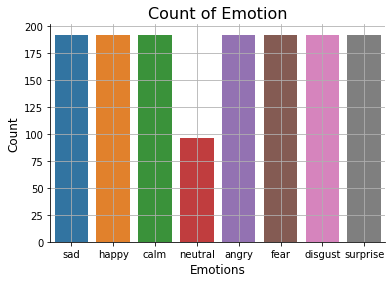

In [5]:
plt.title('Count of Emotion',size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count',size=12)
plt.xlabel('Emotions',size=12)
plt.grid()
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

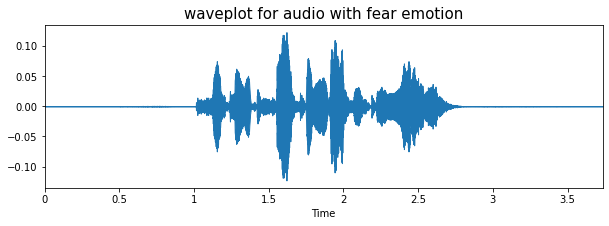

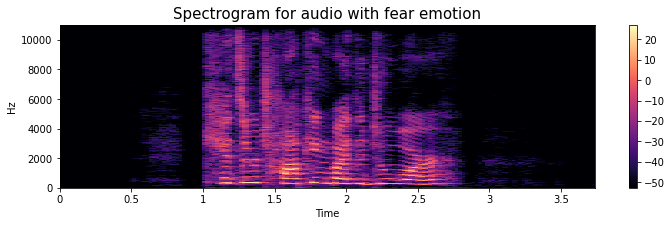

In [6]:
def create_waveplot(data,sr,e):
  plt.figure(figsize=(10,3))
  plt.title('waveplot for audio with {} emotion'.format(e),size=15)
  librosa.display.waveplot(data,sr)
  plt.show()

def create_spectrogram(data,sr,e):
  # STFT : short term fourier transform
  X = librosa.stft(data)
  # amplitude_to_db : amp > db 진폭을 데시벨로 변환
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(12,3))
  plt.title('Spectrogram for audio with {} emotion'.format(e),size=15)
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar()

# test fear's waveplot / spectrogram / audio
emotion = 'fear'
path=np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
# print(path)   /content/drive/MyDrive/kaggle/archive/audio_speech_actors_01-24/Actor_02/03-01-06-01-01-02-02.wav
data, sampling_rate = librosa.load(path) 
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

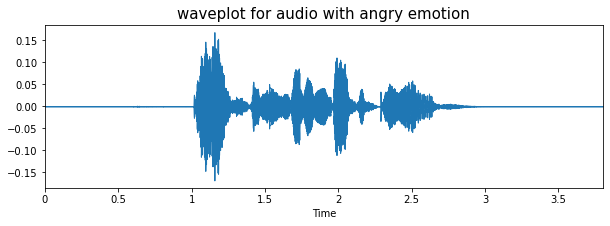

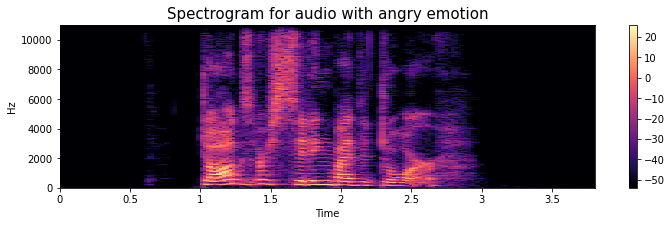

In [ ]:
# test angry
emotion = 'angry'
path=np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [7]:
# data augmentation

def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  #print('noise amp:',noise_amp)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  print('data:',data)
  if (data.max(axis=0) > 32767):
    print("breaking accured...")
  return data

def stretch(data, rate=0.8):
  return librosa.effects.time_stretch(data, rate)

def shift(data):
  shift_data = int(np.random.uniform(low=5,high=5)*1000)
  print('shift data:',shift_data)
  return np.roll(data, shift_data)

def pitch(data, sampling_rate, pitch_factor=0.7):
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def harmonics(data):
  harmonic, percussive = librosa.effects.hpss(data)
  #print(harmonic)
  #print(percussive)
  return percussive, harmonic

path = np.array(Ravdess_df.Path)[1]
data, sampling_rate = librosa.load(path)
#print(path)                  03->'happy'
#print(data)                  [-1.1643693e-07  1.1455914e-07 ...  9.8503428e-08 -6.5785684e-08]
#print(sampling_rate)         22050

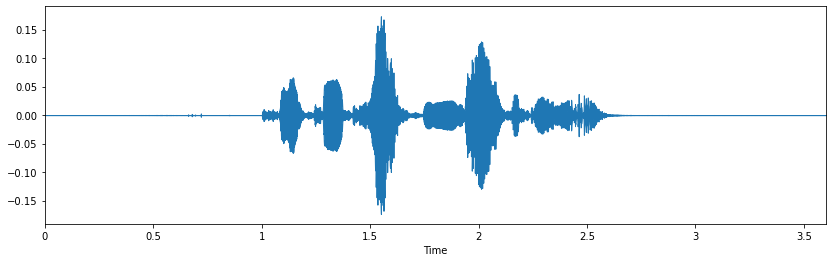

In [ ]:
# simple audio
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data,sr=sampling_rate)
Audio(path)

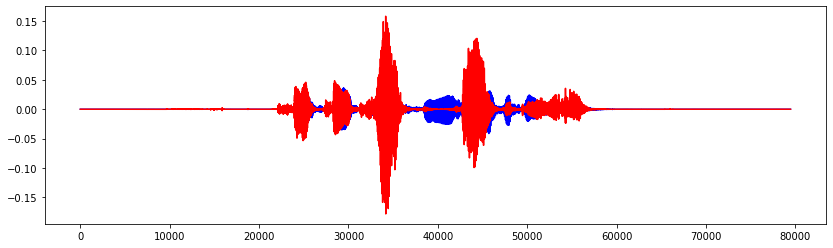

In [ ]:
# harmonics and percussive

harmonic ,percussive = harmonics(data)
plt.figure(figsize=(14,4))
plt.plot(percussive, color='b')
plt.plot(harmonic, color='r')
plt.show()
Audio(percussive, rate=sampling_rate)
#Audio(harmonic, rate=sampling_rate)

noise amp: 0.004359966085849486
data: [ 4.75291951e-04  6.07495216e-03  9.33919785e-05 ... -3.29951696e-03
 -5.84276514e-03 -2.81058387e-03]


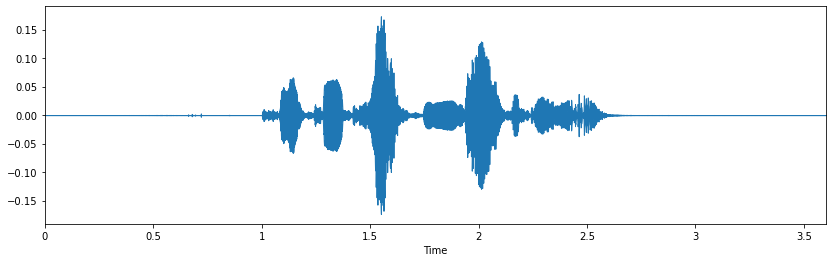

In [ ]:
# noise injection
x=noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sampling_rate)
Audio(x,rate=sampling_rate)

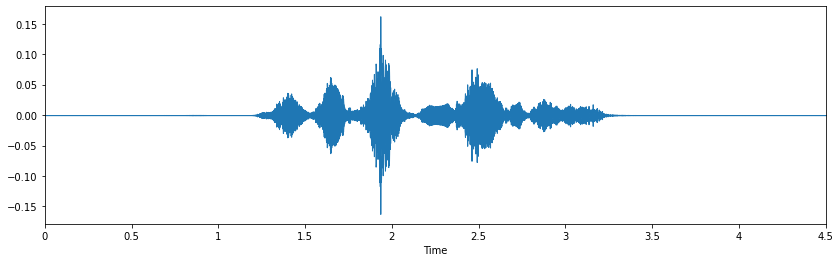

In [ ]:
# stretching
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x,sr=sampling_rate)
Audio(x,rate=sampling_rate)

shift data: 5000


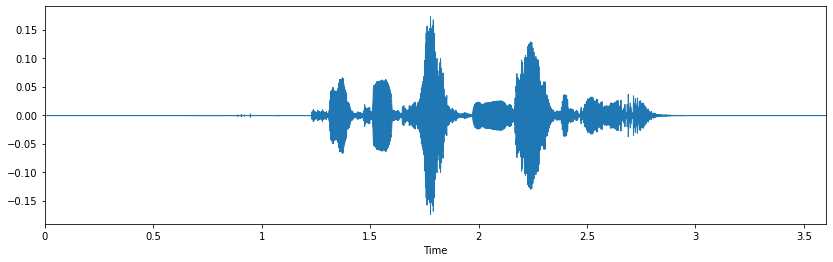

In [ ]:
# shifting
x =shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

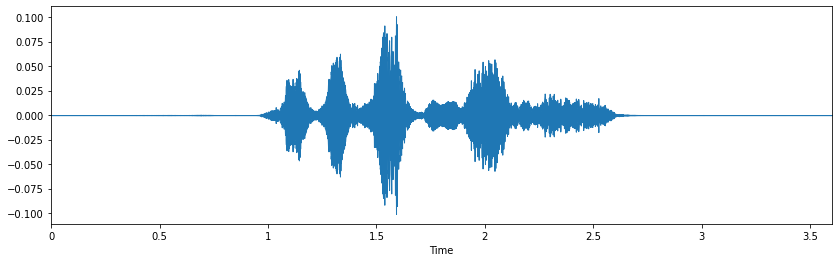

In [ ]:
#pitch
x=pitch(data, sampling_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

In [8]:
# feature extraction
def extract_features(data):
  # ZCR : 음파가 양>음 / 음>양 으로 바뀌는 비율
  result = np.array([])
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result = np.hstack((result,zcr)) # stcking horizontally

  # Chroma_stft: 화음 변화 비율 
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate).T, axis=0)
  result = np.hstack((result, chroma_stft))

  # MFCC : 음성 특징 스펙트럼의 전체적 모양을 축약한 값
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate).T, axis=0)
  result = np.hstack((result, mfcc))

  # Root Mean Square Value: 유성음/ 무성음 구별(음성의 울림 정도) // 소리의 세기
  rms = np.mean(librosa.feature.rms(y=data).T,axis=0)
  result = np.hstack((result,rms))

  # Mel-Spectrogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T, axis=0)
  result = np.hstack((result, mel))

  return result

def get_features(path):
  # duration and offset
  data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)

  # without augmentation
  res1 = extract_features(data)
  result = np.array(res1)
  
  # == data augmentation ==
  # data with noise (잡음 추가)
  nosie_data = noise(data)
  res2 = extract_features(nosie_data)
  result = np.vstack((result, res2))    # stacking vertically

  # data with stretching and pitching (파장늘이기:stretch / 파형이동:shift / 진폭증가: pitch)
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sampling_rate)
  res3 = extract_features(data_stretch_pitch)
  result = np.vstack((result, res3))
  # =========================

  # percussive (리믇과 감정을 나타내는 충격파)
  harmonic_data, percussive_data = harmonics(data)
  res4 = extract_features(percussive_data)
  res5 = extract_features(harmonic_data)
  result = np.vstack((result, res4))
  result = np.vstack((result, res5))

  
  return result

In [10]:
X,Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
  feature = get_features(path)
  for ele in feature:
    X.append(ele)
    #print(X)
    # appending speech data_extracted feature
    Y.append(emotion)
    #print(Y)

data: [ 0.00079758 -0.00054721  0.00054561 ... -0.00285955 -0.00056739
 -0.00074467]
data: [ 1.92567975e-04 -1.26092761e-04  3.32901397e-04 ... -5.16322149e-04
 -8.82139405e-05 -3.96960471e-04]
data: [6.98797963e-05 2.94938991e-04 1.84240745e-04 ... 7.59853268e-04
 7.28612124e-04 5.23368642e-04]
data: [ 0.00047133 -0.00418508  0.00405368 ... -0.00364962  0.00093227
  0.00120919]
data: [-0.00018326 -0.00014701 -0.00015312 ...  0.00040661  0.0003777
  0.00014056]
data: [-0.00362566  0.00902519 -0.00457709 ...  0.00285328  0.00606782
 -0.00062592]
data: [-0.00172804 -0.00153918  0.00074548 ...  0.00219993  0.00310936
  0.00132541]
data: [-0.00081084 -0.00132224  0.00490106 ... -0.00046566  0.00371729
 -0.00120046]
data: [ 0.0004957  -0.00074178 -0.00024177 ...  0.00086155  0.0007681
  0.00102704]
data: [-4.51028957e-04  3.86867717e-06  5.26643178e-04 ...  3.05645462e-04
 -5.63422127e-04 -1.27992785e-04]
data: [ 0.00034042 -0.00070316 -0.00018911 ...  0.00090614  0.0010393
  0.00055873]
da

In [11]:
len(X), len(Y), Ravdess_df.Path.shape

(7200, 7200, (1440,))

In [13]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('/content/drive/MyDrive/features.csv',index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,labels
0,0.174705,0.599538,0.658852,0.550276,0.467596,0.442290,0.467306,0.476679,0.469295,0.522719,0.529621,0.521190,0.554322,-587.024658,64.366913,-10.980195,5.769556,-10.435744,-6.951282,-16.915262,-20.984713,-15.795332,-6.087912,-12.431031,-4.933149,-13.924218,-1.000995,-9.656634,-10.385351,-4.853985,-4.712494,-11.127580,-3.219520,0.005397,1.681152e-06,2.968952e-06,5.992016e-06,0.000062,0.000119,0.000143,...,0.000100,0.000135,0.000173,0.000214,0.000196,0.000210,0.000173,0.000154,0.000108,0.000130,0.000117,0.000105,0.000155,2.259427e-04,2.146134e-04,3.443228e-04,2.452558e-04,1.320921e-04,1.544868e-04,2.130020e-04,1.541756e-04,9.083559e-05,5.224520e-05,3.699812e-05,3.775011e-05,0.000044,0.000054,0.000064,0.000055,4.275741e-05,3.778930e-05,4.406062e-05,4.910666e-05,6.921385e-05,2.759233e-05,2.060759e-05,1.548110e-05,5.230942e-06,6.511832e-07,sad
1,0.293457,0.721320,0.775776,0.703862,0.656045,0.666899,0.681395,0.615507,0.596618,0.651566,0.660765,0.674315,0.711785,-391.422896,21.034785,3.113777,0.434983,-2.747464,-4.134503,-8.141846,-9.621706,-8.493454,-3.881093,-2.203369,-4.080493,-3.931314,-1.135169,-2.689186,-4.228301,-2.363168,-2.905735,-5.698547,-2.412029,0.006065,1.917494e-04,2.249885e-04,1.977448e-04,0.000261,0.000327,0.000298,...,0.000284,0.000324,0.000366,0.000385,0.000371,0.000397,0.000338,0.000315,0.000272,0.000291,0.000300,0.000304,0.000355,4.158383e-04,3.844595e-04,5.359332e-04,4.310911e-04,3.095571e-04,3.353403e-04,3.995519e-04,3.358529e-04,2.767548e-04,2.461560e-04,2.183610e-04,2.287686e-04,0.000216,0.000243,0.000251,0.000236,2.258442e-04,2.297687e-04,2.270114e-04,2.334505e-04,2.581041e-04,2.045885e-04,2.008908e-04,1.997652e-04,1.895273e-04,1.800329e-04,sad
2,0.165082,0.600238,0.723204,0.663467,0.506377,0.462030,0.476203,0.529103,0.507593,0.489589,0.544033,0.553947,0.569833,-643.944702,59.490425,-13.311488,3.311474,-14.516870,-9.358091,-22.844545,-24.208055,-16.267775,-6.765534,-12.750367,-6.859365,-13.991302,-1.593125,-13.598624,-8.763624,-4.337224,-6.490518,-11.409672,-1.809905,0.002592,1.544431e-07,5.745693e-07,7.459005e-07,0.000004,0.000013,0.000017,...,0.000032,0.000021,0.000021,0.000034,0.000042,0.000049,0.000040,0.000031,0.000031,0.000025,0.000020,0.000017,0.000024,2.624580e-05,5.480861e-05,4.053419e-05,6.903265e-05,7.225979e-05,5.046867e-05,2.390032e-05,6.694382e-05,5.335610e-05,3.042970e-05,1.749819e-05,7.933114e-06,0.000008,0.000009,0.000011,0.000012,1.418112e-05,1.464882e-05,8.863502e-06,7.918336e-06,8.010228e-06,1.306121e-05,9.299884e-06,3.763073e-06,1.065847e-06,7.085685e-08,sad
3,0.101138,0.669051,0.672008,0.453220,0.415624,0.365449,0.331702,0.340748,0.401071,0.470680,0.478200,0.549041,0.566049,-684.862366,66.163101,-5.127938,15.001857,-6.037711,-10.715798,-15.028687,-21.480301,-16.748404,-8.107706,-12.859098,-4.068806,-14.990026,-0.463658,-12.189271,-14.340026,-6.132235,-9.139083,-13.722310,-7.363494,0.003106,1.152110e-07,2.329658e-07,4.950145e-07,0.000003,0.000005,0.000011,...,0.000005,0.000004,0.000005,0.000011,0.000012,0.000019,0.000012,0.000014,0.000008,0.000006,0.000004,0.000002,0.000001,5.632974e-07,3.558225e-07,3.796217e-07,4.941616e-07,4.513790e-07,6.418833e-07,8.594573e-07,8.735529e-07,9.159475e-07,2.646717e-07,2.587669e-07,4.088248e-07,0.000001,0.000001,0.000002,0.000002,5.796108e-07,4.323696e-07,4.120948e-07,2.187303e-07,1.957026e-07,1.591812e-07,1.621487e-07,1.516423e-07,5.364659e-08,6.659928e-09,sad
4,0.189571,0.649796,0.638255,0.619838,0.613410,0.613200,0.664746,0.660321,0.646059,0.649743,0.584337,0.557461,0.593527,-639.705078,48.474991,-16.214085,-0.572595,-14.576268,-7.815876,-15.665545,-19.124828,-13.359921,-3.598437,-7.905519,-1.025733,-8.295756,3.466699,-3.618813,-4.043652,0.581232,0.353624,-5.082979,1.655479,0.003

In [26]:
X = Features.iloc[:,:-1].values
# print(X)        [[1.74705223e-01 5.99538445e-01 ... 1.54811041e-05 5.23094195e-06 6.51183200e-07]
Y = Features['labels'].values
# print(Y)        ['sad' 'sad' 'sad' ... 'surprise' 'surprise' 'surprise']
x_train, x_test, y_train, y_test = train_test_split(X,Y,random_state=0, shuffle=True)

x_train.shape, y_train.shape, x_test.shape, y_test.shape
# ((3240, 162), (3240,), (1080, 162), (1080,))

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
#plt.scatter(x_train[:,0],x_train[:,1])
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# ((3240, 162), (3240,), (1080, 162), (1080,))

((5400, 162), (5400,), (1800, 162), (1800,))

In [27]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test,axis=2)
#print(x_train)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# ((3240, 162, 1), (3240,), (1080, 162, 1), (1080,))


((5400, 162, 1), (5400,), (1800, 162, 1), (1800,))

In [ ]:
x_train.dtype, x_test.dtype,y_train.dtype, y_test.dtype 

(dtype('float64'), dtype('float64'), dtype('O'), dtype('O'))

In [ ]:
print(y_train)

['calm' 'surprise' 'neutral' ... 'calm' 'angry' 'neutral']


In [ ]:
print(x_train.shape[2])

1


In [28]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
#print(y_train)

y_test = encoder.fit_transform(y_test)

In [29]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPool1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(8, activation='softmax'))
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 81, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 128)           0

In [30]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history= model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
85/85 [==============================] - 34s 388ms/step - loss: 2.0097 - accuracy: 0.1991 - val_loss: 1.9728 - val_accuracy: 0.1950
Epoch 2/50
85/85 [==============================] - 33s 384ms/step - loss: 1.9135 - accuracy: 0.2478 - val_loss: 1.8445 - val_accuracy: 0.2944
Epoch 3/50
85/85 [==============================] - 32s 381ms/step - loss: 1.8302 - accuracy: 0.2798 - val_loss: 1.8512 - val_accuracy: 0.2794
Epoch 4/50
85/85 [==============================] - 33s 385ms/step - loss: 1.7710 - accuracy: 0.3133 - val_loss: 1.6847 - val_accuracy: 0.3750
Epoch 5/50
85/85 [==============================] - 33s 383ms/step - loss: 1.7116 - accuracy: 0.3396 - val_loss: 1.6034 - val_accuracy: 0.3950
Epoch 6/50
85/85 [==============================] - 32s 382ms/step - loss: 1.6405 - accuracy: 0.3696 - val_loss: 1.6235 - val_accuracy: 0.3828
Epoch 7/50
85/85 [==============================] - 33s 385ms/step - loss: 1.5910 - accuracy: 0.3998 - val_loss: 1.5818 - val_accuracy: 0.3789

57/57 [==============================] - 2s 41ms/step - loss: 1.3020 - accuracy: 0.7194
accuracy of model on test data: 71.94444537162781 %


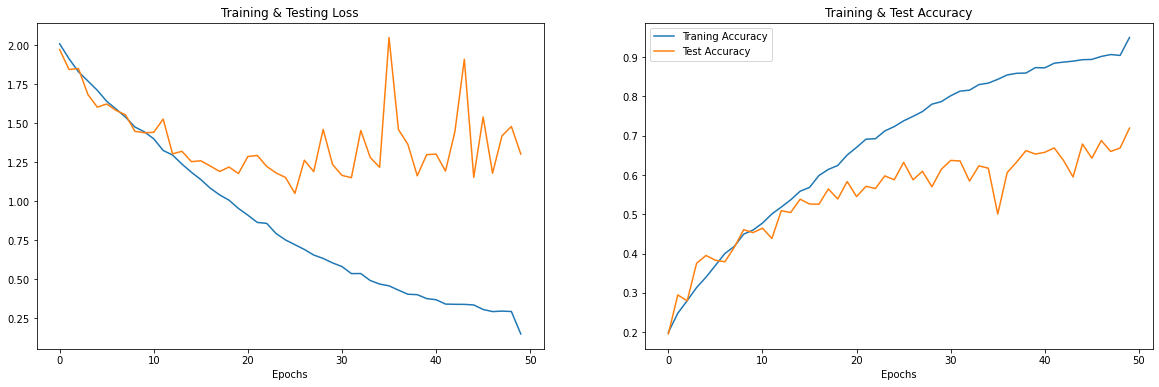

In [31]:
print("accuracy of model on test data:", model.evaluate(x_test, y_test)[1]*100,"%")

epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title("Training & Testing Loss")
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Traning Accuracy')
ax[1].plot(epochs, test_acc, label='Test Accuracy')
ax[1].set_title('Training & Test Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epochs')

plt.show()

In [32]:
model.save('/content/drive/MyDrive/speech_emotion_recog.h5')

In [34]:
model.load_weights('/content/drive/MyDrive/speech_emotion_recog.h5')
print(model.weights)

[<tf.Variable 'conv1d/kernel:0' shape=(5, 1, 256) dtype=float32, numpy=
array([[[ 0.04911131,  0.00175192,  0.08699843, ...,  0.0333931 ,
         -0.09258464, -0.05499271]],

       [[ 0.07543582,  0.07321844, -0.04756108, ...,  0.09094434,
          0.0438454 , -0.06385124]],

       [[-0.16027923,  0.01963173, -0.12762965, ..., -0.06716508,
          0.00071335,  0.02119607]],

       [[ 0.06857032, -0.10051661, -0.12105639, ..., -0.12611878,
          0.03177464, -0.0540926 ]],

       [[ 0.02266299,  0.0216762 ,  0.14441733, ...,  0.04001023,
         -0.08932847,  0.13940911]]], dtype=float32)>, <tf.Variable 'conv1d/bias:0' shape=(256,) dtype=float32, numpy=
array([-1.17294952e-01, -1.02129035e-01, -1.29593238e-01, -2.96645425e-02,
       -4.49889712e-03, -7.97100216e-02, -7.32104778e-02, -8.48131720e-03,
       -1.34432977e-02, -7.51550421e-02, -2.40204595e-02, -6.23389557e-02,
       -1.93649158e-01, -1.07014492e-01, -1.16510965e-01, -3.91118005e-02,
       -8.47339688e-04, -8.

In [ ]:
#model.save('speech_emotion_recog_addHamonics.h5')

In [ ]:
#model.save_weights('speech_emotion_recog_weights.h5')